In [480]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

sns.set_style(style="darkgrid")

## 🧹🔍Exploración y limpieza de los datos🔎🧹

In [481]:
df = pd.read_csv('data/dataset_practica_final.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [482]:
df.info()
#* is_canceled es la variable objetivo, que indica si una reserva fue cancelada (1) o no (0).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [483]:
df.shape

(119390, 32)

📊 Variables categóricas:
Variable original
| Variable original         | Descripción                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| hotel                    | Tipo de hotel: City Hotel o Resort Hotel                                    |
| arrival_date_month       | Mes de llegada: January–December                                            |
| meal                     | Tipo de comida incluida                                                     |
| country                  | País de origen del cliente                                                  |
| market_segment           | Canal de origen del cliente (por ejemplo, Online TA, Groups, etc.)          |
| distribution_channel     | Canal de distribución usado                                                 |
| reserved_room_type       | Tipo de habitación reservada                                                |
| assigned_room_type       | Tipo de habitación asignada finalmente                                      |
| deposit_type             | Tipo de depósito: No Deposit, Non Refund, Refundable                        |
| customer_type            | Tipo de cliente: Transient, Contract, Group, Transient-Party                |
| reservation_status       | Estado final de la reserva (Cancelado, No show, Check-out)     |
| reservation_status_date  | Fecha de estado final                                       |

**reservation_status** y **reservation_status_date** son variables que no nos aportan mucho valor a la hora de predecir si una reserva se cancela o no, ya que son el resultado de la cancelación. Por lo tanto, las eliminaremos.

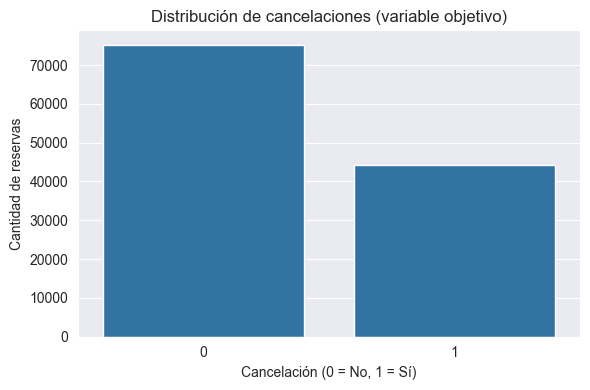

In [484]:
# Distribución de la variable objetivo
plt.figure(figsize=(6, 4))
sns.countplot(x='is_canceled', data=df)
plt.title('Distribución de cancelaciones (variable objetivo)')
plt.xlabel('Cancelación (0 = No, 1 = Sí)')
plt.ylabel('Cantidad de reservas')
plt.tight_layout()
plt.show()

In [485]:
df['is_canceled'].value_counts(normalize=True)

is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64

El 37% de las muestras son clientes que cancelaron su reserva

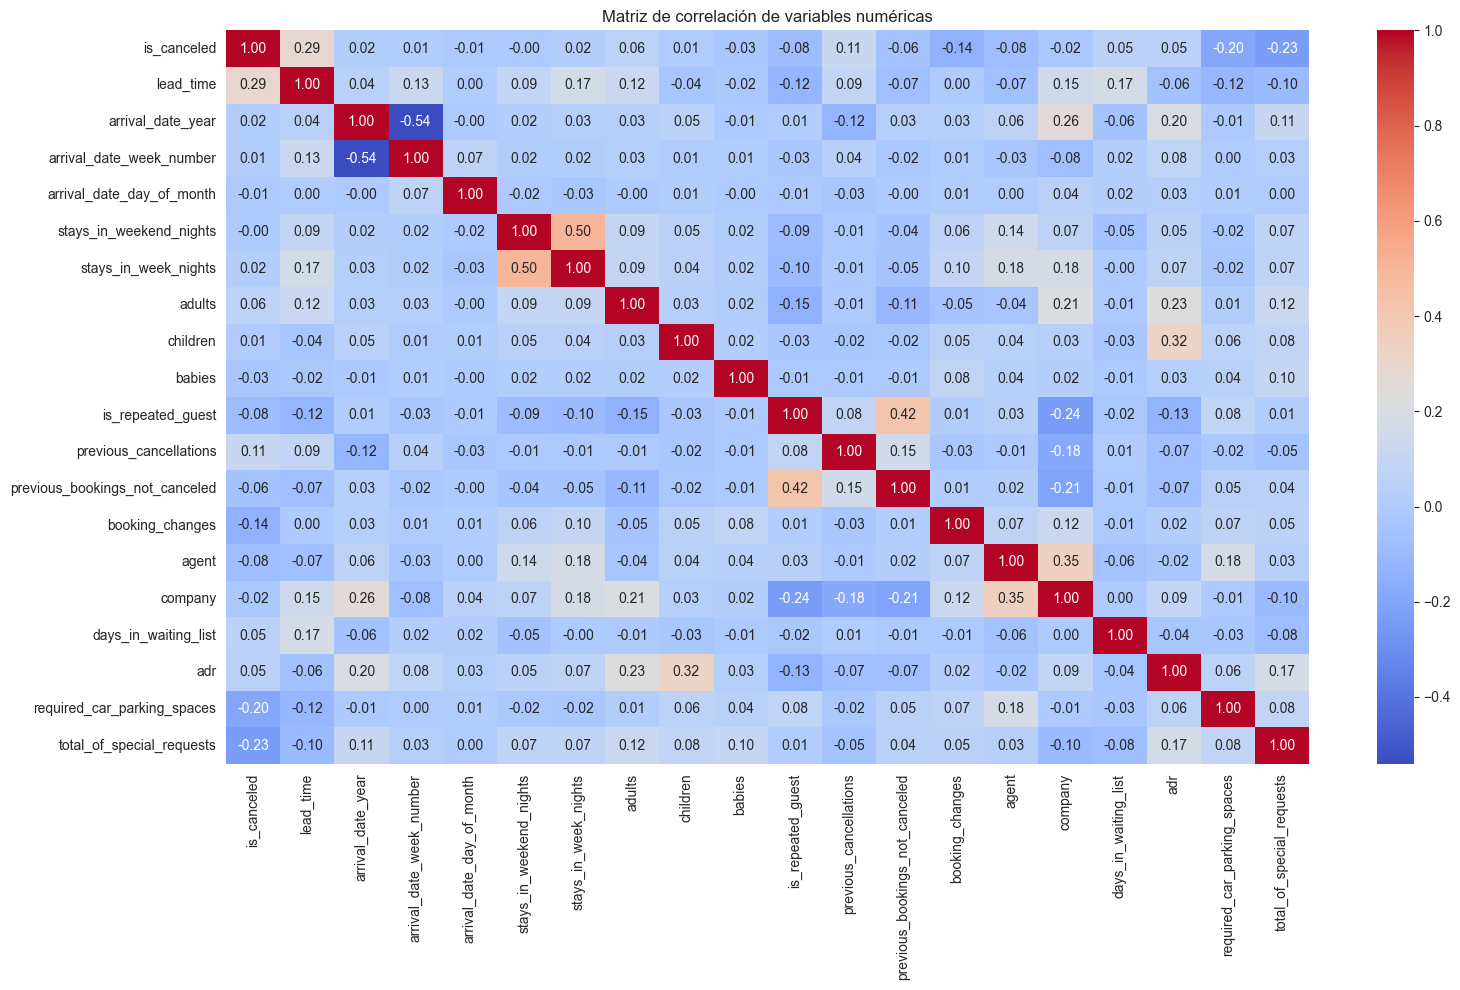

In [486]:
# Mapa de calor de correlación de variables numéricas
plt.figure(figsize=(16, 10))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriz de correlación de variables numéricas')
plt.tight_layout()
plt.show()

In [487]:
# Verificar duplicados
duplicated_rows = df.duplicated().sum()
duplicated_rows

np.int64(31994)

In [488]:
# Verificar valores nulos por columna
null_values = df.isnull().sum().sort_values(ascending=False)
null_values

company                           112593
agent                              16340
country                              488
children                               4
arrival_date_month                     0
arrival_date_week_number               0
hotel                                  0
is_canceled                            0
stays_in_weekend_nights                0
arrival_date_day_of_month              0
adults                                 0
stays_in_week_nights                   0
babies                                 0
meal                                   0
lead_time                              0
arrival_date_year                      0
distribution_channel                   0
market_segment                         0
previous_bookings_not_canceled         0
is_repeated_guest                      0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
previous_cancellations                 0
deposit_type    

In [489]:
print(f"Columna company: {(df['company'].isnull().sum() / df.shape[0]).round(4)*100} % de valores nulos")
print(f"Columna agent: {(df['agent'].isnull().sum() / df.shape[0]).round(4)*100} % de valores nulos")
print(f"Columna country: {(df['country'].isnull().sum() / df.shape[0]).round(3)*100} % de valores nulos")
print(f"Columna children: {(df['children'].isnull().sum() / df.shape[0]).round(10)*100} % de valores nulos")

Columna company: 94.31 % de valores nulos
Columna agent: 13.69 % de valores nulos
Columna country: 0.4 % de valores nulos
Columna children: 0.00335036 % de valores nulos


- 31994 filas duplicadas ---> Las eliminaremos para evitar sesgos y sobreajuste. ❌
- *company*: 112,593 nulos (~94%) → Eliminaremos la columna por escasa información. ❌
- *country*: 488 nulos → Los imputaremos con el valor más frecuente. 🧠
- *children*: solo 4 nulos → Los imputaremos con la mediana. 🧠

In [490]:
# Eliminar duplicados
df_clean = df.drop_duplicates().copy()

In [491]:
# Eliminamos la columna 'company' (muchos nulos)
df_clean = df_clean.drop(columns=['company'])

In [492]:
# Imputar 'children' con mediana
df_clean['children'] = df_clean['children'].fillna(df_clean['children'].median())

# Imputar 'country' con el valor más frecuente (moda)
df_clean['country'] = df_clean['country'].fillna(df_clean['country'].mode()[0])

# Imputar 'agent' con 0 (representa 'no especificado')
df_clean['agent'] = df_clean['agent'].fillna(0)

In [493]:
# Verificar que no quedan nulos
null_check_post_cleaning = df_clean.isnull().sum().sum()
df_clean.shape, null_check_post_cleaning

((87396, 31), np.int64(0))

Las dimensiones del dataset se han reducido a 87396 filas y 31 columnas, y no quedan valores nulos.

## 💎 Preprocesamiento de los datos

In [494]:
# Definir variable objetivo y eliminar columnas no útiles
target = 'is_canceled'
drop_cols = ['reservation_status', 'reservation_status_date']  # columnas que no se conocen antes de la reserva
df_model = df_clean.drop(columns=drop_cols)

df_model.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,C,C,3,No Deposit,0.0,0,Transient,0.0,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,C,C,4,No Deposit,0.0,0,Transient,0.0,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,A,C,0,No Deposit,0.0,0,Transient,75.0,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1


In [495]:
# Codificar variables categóricas
df_encoded = pd.get_dummies(df_model, drop_first=True)
df_encoded

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,2015,27,1,0,0,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False
1,0,737,2015,27,1,0,0,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False
2,0,7,2015,27,1,0,1,1,0.0,0,...,False,False,False,False,False,False,False,False,True,False
3,0,13,2015,27,1,0,1,1,0.0,0,...,False,False,False,False,False,False,False,False,True,False
4,0,14,2015,27,1,0,2,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,35,30,2,5,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False
119386,0,102,2017,35,31,2,5,3,0.0,0,...,False,False,False,False,False,False,False,False,True,False
119387,0,34,2017,35,31,2,5,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False
119388,0,109,2017,35,31,2,5,2,0.0,0,...,False,False,False,False,False,False,False,False,True,False


Ahora tenemos 247 columnas 🤯, aunque nos ayudará para capturar la información de las variables categóricas.
Algunas columnas pueden ser redundantes, pero es mejor tener más información que menos.

In [496]:
# Separamos las variables independientes (X) de la variable dependiente (target) (y)
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

In [497]:
X

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342,2015,27,1,0,0,2,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
1,737,2015,27,1,0,0,2,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
2,7,2015,27,1,0,1,1,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,13,2015,27,1,0,1,1,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,14,2015,27,1,0,2,2,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,2017,35,30,2,5,2,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
119386,102,2017,35,31,2,5,3,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
119387,34,2017,35,31,2,5,2,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False
119388,109,2017,35,31,2,5,2,0.0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [498]:
y

0         0
1         0
2         0
3         0
4         0
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: is_canceled, Length: 87396, dtype: int64

In [499]:
# Escalamos las variables numéricas
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

scaler

,copy,True
,with_mean,True
,with_std,True


🔥 Hasta este punto del Notebook, lo podremos reutilizar para el resto de algoritmos a implementar en la práctica final.
- Crearemos un archivo *dataset_practica_final_preprocessed.csv* con los datos limpios y preprocesados.
- Así en el resto de algoritmos solo tendremos que separar las columnas independientes de la dependiente

In [500]:
df_to_save = X.copy()
df_to_save['is_canceled'] = y
df_to_save.to_csv('data/dataset_practica_final_preprocessed.csv', index=False)

In [501]:
# Dividir en conjunto de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

#* stratify hace que la proporción de cancelados y no cancelados sea muy similar en datos de train y test

((69916, 246),
 (17480, 246),
 is_canceled
 0    0.725099
 1    0.274901
 Name: proportion, dtype: float64,
 is_canceled
 0    0.725114
 1    0.274886
 Name: proportion, dtype: float64)

🤖 Creamos el Modelo de Regresión Logística, lo entrenamos y hacemos predicciones para ver como funciona.
- Usamos GridSearch para optimizar los hiperparámetros del modelo.
Código copiado de la Clase 2 :)

In [502]:
#- Entrenamos un modelo usando GridSearchCV para encontrar los mejores hiperparámetros
dict_parametros = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# modelo_rl = LogisticRegression(max_iter=500, random_state=42, class_weight="balanced")
#Accuracy:  0.75
# Precisión: 0.53
# Recall:    0.79
# F1-Score:  0.64
# AUC:       0.85

modelo_rl = LogisticRegression(max_iter=500, random_state=42, class_weight="balanced")
modelo_rl_cv = GridSearchCV(modelo_rl, dict_parametros, cv=5, scoring='accuracy')
modelo_rl_cv.fit(X_train, y_train)

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.01, 0.1, ...], 'solver': ['liblinear']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [503]:
# 2. Predicciones y probabilidades
y_pred = modelo_rl_cv.predict(X_test)
y_proba = modelo_rl_cv.predict_proba(X_test)[:, 1]

y_pred, y_proba

#* Si la probabilidad es mayor al 50% se considera que la reserva se cancelará (1), de lo contrario, no se cancelará (0).

(array([0, 1, 1, ..., 0, 0, 0], shape=(17480,)),
 array([0.3863333 , 0.6954003 , 0.79009093, ..., 0.48732851, 0.36216031,
        0.068141  ], shape=(17480,)))

## Evaluación del modelo

In [504]:
#* Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

#* Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n"

Accuracy:  0.75
Precisión: 0.53
Recall:    0.79
F1-Score:  0.64
AUC:       0.85



In [505]:
# Gracias a la función classification_report podemos obtener un reporte detallado de las métricas de evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81     12675
           1       0.53      0.79      0.64      4805

    accuracy                           0.75     17480
   macro avg       0.72      0.76      0.72     17480
weighted avg       0.80      0.75      0.76     17480



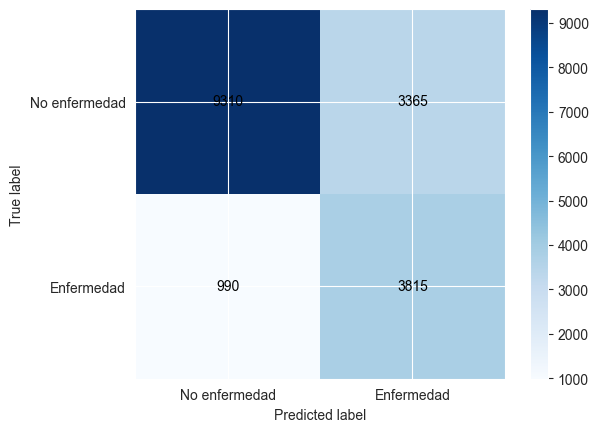

In [506]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No enfermedad', 'Enfermedad'])

fig, ax = plt.subplots()
disp.plot(cmap='Blues', ax=ax, colorbar=True)

# Ajustar los textos para que sean legibles
for texts in disp.text_.ravel():
    texts.set_color('black')  # Cambia el color de texto a negro

plt.show()

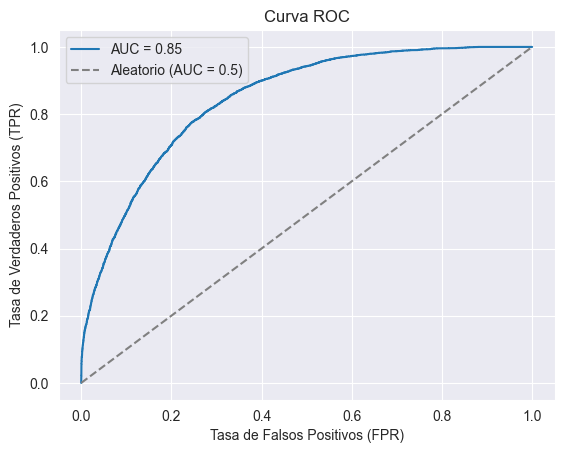

In [507]:
# Curva ROC
#- Cuanto más se aproxime a 1 la ROC (AUC), Mejor
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()